In [2]:
import sys 
import nibabel as nib 
import matplotlib.pyplot as plt 
import numpy as np 
import regtricks as rt 
from scipy import stats 
from scipy.ndimage import binary_erosion

sys.path.insert(1, '/Users/thomaskirk/Modules/svb_module')
from svb.main import run

In [3]:
SIGNAL = 10 
NOISE = 10
REPEATS = 100
spc = rt.ImageSpace.create_axis_aligned([0,0,0], 60 * np.ones(3), np.ones(3))
data = np.random.normal(SIGNAL, NOISE, size=(REPEATS))

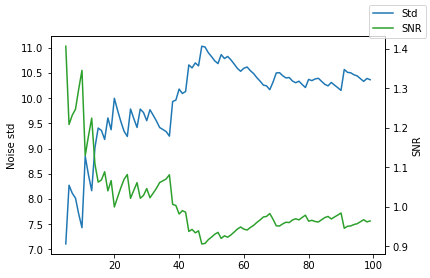

In [4]:
snr_time = []
std_time = []
mean_time = [] 
repeats = np.arange(5, REPEATS)
for rpt in repeats: 
    d = data[...,:rpt]
    s = np.sqrt(((d - SIGNAL) ** 2).mean() )
    std_time.append(s)
    snr_time.append( (SIGNAL / s).mean() )

fig, ax = plt.subplots()
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.plot(repeats, std_time, label='Std')
ax.set_ylabel("Noise std")

ax2 = ax.twinx()
# ax.set_yscale('log')
ax2.plot(repeats, snr_time, label='SNR', color='tab:green')
ax2.set_ylabel("SNR")
fig.legend()

In [5]:
spc = rt.ImageSpace.create_axis_aligned([0,0,0], 60 * np.ones(3), np.ones(3))
data = np.random.normal(SIGNAL, NOISE, size=(*spc.size, REPEATS))

In [6]:
snr = []
std = []
mean = [] 

scales = np.arange(1,7)
for scale in scales: 
    spc2 = spc.resize_voxels(scale)
    d = rt.Registration.identity().apply_to_array(data, spc, spc2, order=1)
    m = d.mean(-1)
    s = d.std(-1)
    std.append(s.mean())
    mean.append(m.mean())
    snr.append( (SIGNAL / s).mean() )

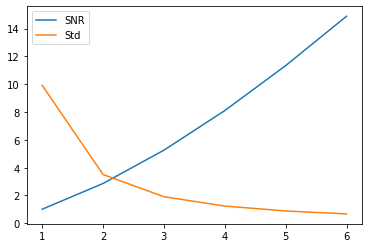

In [7]:
plt.plot(scales, snr, label='SNR')
# plt.plot(scales, mean, label='Mean')
plt.plot(scales, std, label='Std')
plt.legend()

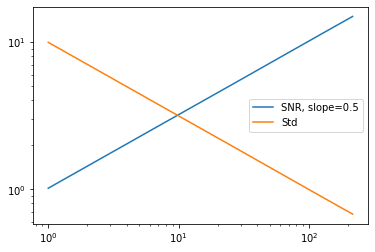

In [8]:
vox_vol = scales ** 3 
reg = stats.linregress(np.log(vox_vol), np.log(snr))

fig, ax = plt.subplots()
ax.plot(vox_vol, snr, label=f'SNR, slope={reg.slope:.1f}')
ax.plot(vox_vol, std, label='Std')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

In [9]:
# single TI mode 
data = '/Users/thomaskirk/Data/singlePLDpcASL/asl_diff.nii.gz'
mask = '/Users/thomaskirk/Data/singlePLDpcASL/asl_mask_ero.nii.gz'
spc = rt.ImageSpace(mask)

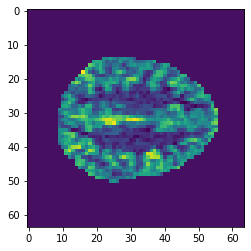

In [10]:
data_arr = nib.load(data).get_fdata()
mask_arr = nib.load(mask).get_fdata().astype(bool)
data_arr[~mask_arr,:] = 0 
plt.imshow(data_arr.mean(-1)[:,:,15])

In [11]:
sig = data_arr[mask_arr,:].mean(-1)
noise = data_arr[mask_arr,:].std(-1)
gm = (sig > np.percentile(sig, 80))
snr_vox = sig[gm] / noise[gm]
snr_vox = snr_vox.mean()
print('Mean signal', sig[gm].mean(), 'mean noise std', noise[gm].mean(), 'snr at 3.5mm', snr_vox)

Mean signal 4.838825995807127 mean noise std 2.4600107189421427 snr at 3.5mm 2.372035139064916


In [12]:
# There is weak variation with number of repeats 
# Stronger variation with voxel size 
# Let SNR = mu * (vol^0.5) / std 
snr_base = snr_vox / (spc.vox_size.prod() ** 0.5)
snr_base 

0.3101528815178598

In [13]:
noise_base = sig[gm].mean() / snr_base
noise_base

15.601422021702188

In [14]:
noise_base / (spc.vox_size.prod() ** 0.5)

2.0399470126377004

In [15]:
snr = [] 
scales = np.arange(1,6)
for scale in scales: 
    spc2 = spc.resize_voxels(scale)
    data2 = rt.Registration.identity().apply_to_array(data_arr, spc, spc2, order=1)
    mask2 = (rt.Registration.identity().apply_to_array(mask_arr, spc, spc2, order=1) > 0.8)
    sig = data2[mask2,:].mean(-1)
    noise = data2[mask2,:].std(-1)
    gm = (sig > np.percentile(sig, 80))
    s = sig[gm] / noise[gm]
    snr.append(s.mean())


LinregressResult(slope=0.5423763698472642, intercept=-1.3120378443795622, rvalue=0.9953119623448119, pvalue=0.0003850479899877683, stderr=0.030428592047197327, intercept_stderr=0.15392038400556823)

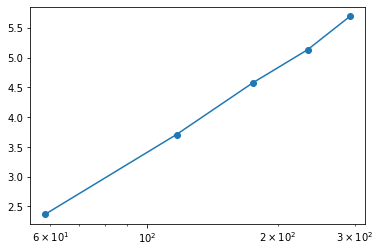

In [16]:
fig, ax = plt.subplots()
vols = [ s * spc.vox_size.prod() for s in scales ]
ax.plot(vols, snr, marker='o')
# ax.set_yscale('log')
ax.set_xscale('log')
stats.linregress(np.log(vols), np.log(snr))

In [17]:
spc.vox_size.prod()

58.49120868369937

In [18]:
# snr(58.49) = 2.37 
# snr(x) = 2.37 * (x / 58.49) ^ 0.5

LinregressResult(slope=0.5423763698472642, intercept=-1.3120378443795622, rvalue=0.9953119623448119, pvalue=0.0003850479899877683, stderr=0.030428592047197327, intercept_stderr=0.15392038400556823)

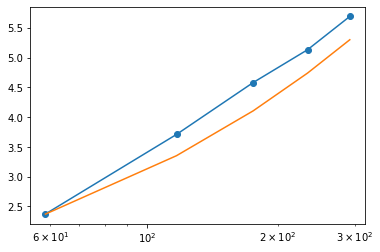

In [19]:
fig, ax = plt.subplots()
vols = [ s * spc.vox_size.prod() for s in scales ]
snr2 = [ 2.37 * ((s * spc.vox_size.prod() / 58.49) ** 0.5) for s in scales ]
ax.plot(vols, snr, marker='o')
ax.plot(vols, snr2)
# ax.set_yscale('log')
ax.set_xscale('log')
stats.linregress(np.log(vols), np.log(snr))

In [36]:
# multi TI mode 
data_full = '/Users/thomaskirk/Data/pcasl2/derivatives/fitted/sub-1/sub-1_sess-A_run-1_space-native_pvec-tob/input/asldata.nii.gz'
mask = '/Users/thomaskirk/Data/pcasl2/derivatives/fitted/sub-1/sub-1_sess-A_run-1_space-native_pvec-tob/input/mask.nii.gz'
spc = rt.ImageSpace(mask)

In [37]:
mask_arr = nib.load(mask).get_fdata().astype(bool)
data_arr = nib.load(data_full).get_fdata()
diff_data = data_arr[...,1::2] - data_arr[...,0::2]
data_arr = diff_data 
data_arr[~mask_arr,:] = 0 

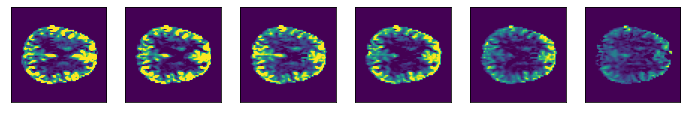

In [40]:
fig, axes = plt.subplots(1,6, figsize=(12,2))
for pld, ax in enumerate(axes): 
    ax.imshow(data_arr[:,:,12,pld::6].mean(-1), vmin=0, vmax=15)
    ax.set_xticks([])
    ax.set_yticks([])

(4.2130413257947374, 1.117108397300833, 2.8479333345325384)

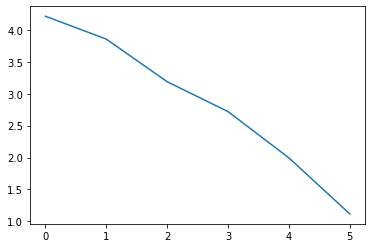

In [45]:
snrs = []
sig_all = data_arr[mask_arr,:].mean(-1)
gm = sig_all > np.percentile(sig_all, 80)

for pld in range(6): 
    data_pld = data_arr[mask_arr,pld::6]
    sig = data_pld.mean(-1)
    noise = data_pld.std(-1)
    snrs.append( (sig[gm] / noise[gm]).mean() )

plt.plot(snrs)
snrs[0], snrs[-1], np.mean(snrs)

In [79]:
spc.vox_size.prod()

58.49121449787077

In [ ]:
noise_base = sig[gm].mean() / snr_base
noise_base

15.601422021702188

In [ ]:
noise_base / (spc.vox_size.prod() ** 0.5)

2.0399470126377004

In [ ]:
snr = [] 
scales = np.arange(1,6)
for scale in scales: 
    spc2 = spc.resize_voxels(scale)
    data2 = rt.Registration.identity().apply_to_array(data_arr, spc, spc2, order=1)
    mask2 = (rt.Registration.identity().apply_to_array(mask_arr, spc, spc2, order=1) > 0.8)
    sig = data2[mask2,:].mean(-1)
    noise = data2[mask2,:].std(-1)
    gm = (sig > np.percentile(sig, 80))
    s = sig[gm] / noise[gm]
    snr.append(s.mean())


LinregressResult(slope=0.5423763698472642, intercept=-1.3120378982931176, rvalue=0.9953119623448119, pvalue=0.0003850479899877683, stderr=0.030428592047197323, intercept_stderr=0.15392038701108848)

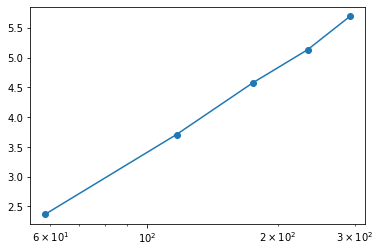

In [ ]:
fig, ax = plt.subplots()
vols = [ s * spc.vox_size.prod() for s in scales ]
ax.plot(vols, snr, marker='o')
# ax.set_yscale('log')
ax.set_xscale('log')
stats.linregress(np.log(vols), np.log(snr))

In [ ]:
spc.vox_size.prod()

58.49120868369937

In [ ]:
# snr(58.49) = 2.37 
# snr(x) = 2.37 * (x / 58.49) ^ 0.5

2.372035139064916

LinregressResult(slope=0.5423763698472642, intercept=-1.3120378982931176, rvalue=0.9953119623448119, pvalue=0.0003850479899877683, stderr=0.030428592047197323, intercept_stderr=0.15392038701108848)

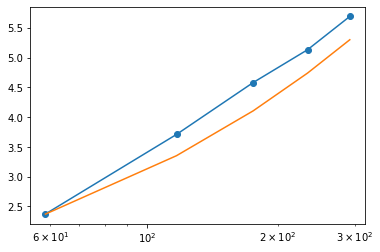

In [ ]:
fig, ax = plt.subplots()
vols = [ s * spc.vox_size.prod() for s in scales ]
snr2 = [ 2.37 * ((s * spc.vox_size.prod() / 58.49) ** 0.5) for s in scales ]
ax.plot(vols, snr, marker='o')
ax.plot(vols, snr2)
# ax.set_yscale('log')
ax.set_xscale('log')
stats.linregress(np.log(vols), np.log(snr))

In [ ]:
# multi TI mode 
data = '/Users/thomaskirk/Data/pcasl2/derivatives/preprocessed/sub-1/sub-1_sess-A_run-1_space-native_acq-asl_rest.nii.gz'
mask = '/Users/thomaskirk/Data/pcasl2/derivatives/preprocessed/sub-1/sub-1_sess-A_run-1_space-native_mask.nii.gz'
spc = rt.ImageSpace(mask)